<a href="https://colab.research.google.com/github/Viny2030/sklearn/blob/main/cross_validation_nested.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nested cross-validation

Cross-validation can be used both for hyperparameter tuning and for estimating
the generalization performance of a model. However, using it for both purposes
at the same time is problematic, as the resulting evaluation can underestimate
some overfitting that results from the hyperparameter tuning procedure itself.

Philosophically, hyperparameter tuning is a form of machine learning itself
and therefore, we need another outer loop of cross-validation to properly
evaluate the generalization performance of the full modeling procedure.

This notebook highlights nested cross-validation and its impact on the
estimated generalization performance compared to naively using a single level
of cross-validation, both for hyperparameter tuning and evaluation of the
generalization performance.

We will illustrate this difference using the breast cancer dataset.

# **Validación cruzada anidada**
La validación cruzada se puede utilizar tanto para ajustar los hiperparámetros como para estimar el rendimiento de generalización de un modelo. Sin embargo, su uso para ambos fines al mismo tiempo es problemático, ya que la evaluación resultante puede subestimar algún sobreajuste que resulta del propio procedimiento de ajuste de hiperparámetros.

Filosóficamente, el ajuste de hiperparámetros es una forma de aprendizaje automático en sí mismo y, por lo tanto, necesitamos otro ciclo externo de validación cruzada para evaluar adecuadamente el rendimiento de generalización del procedimiento de modelado completo.

Este cuaderno destaca la validación cruzada anidada y su impacto en el rendimiento de generalización estimado en comparación con el uso ingenuo de un solo nivel de validación cruzada, tanto para el ajuste de hiperparámetros como para la evaluación del rendimiento de generalización.

Ilustraremos esta diferencia utilizando el conjunto de datos de cáncer de mama.


In [1]:
from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(return_X_y=True)

First, we use `GridSearchCV` to find the best parameters via cross-validation
on a minimal parameter grid.

Primero, usamos GridSearchCV para encontrar los mejores parámetros a través de la validación cruzada en una cuadrícula de parámetros mínima.

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10], "gamma": [0.01, 0.1]}
model_to_tune = SVC()

search = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, n_jobs=2)
search.fit(data, target)

GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

We recall that, internally, `GridSearchCV` trains several models for each on
sub-sampled training sets and evaluate each of them on the matching testing
sets using cross-validation. This evaluation procedure is controlled via using
the `cv` parameter. The procedure is then repeated for all possible
combinations of parameters given in `param_grid`.

The attribute `best_params_` gives us the best set of parameters that maximize
the mean score on the internal test sets.

Recordamos que, internamente, GridSearchCV entrena varios modelos para cada uno de ellos en conjuntos de entrenamiento submuestreados y evalúa cada uno de ellos en los conjuntos de prueba coincidentes mediante validación cruzada. Este procedimiento de evaluación se controla mediante el parámetro cv. Luego, el procedimiento se repite para todas las combinaciones posibles de parámetros proporcionados en param_grid.

El atributo best_params_ nos brinda el mejor conjunto de parámetros que maximizan la puntuación media en los conjuntos de prueba internos.

In [3]:
print(f"The best parameters found are: {search.best_params_}")

The best parameters found are: {'C': 0.1, 'gamma': 0.01}


We can also show the mean score obtained by using the parameters `best_params_`.

También podemos mostrar la puntuación media obtenida utilizando los parámetros best_params_.

In [4]:
print(f"The mean CV score of the best model is: {search.best_score_:.3f}")

The mean CV score of the best model is: 0.627


At this stage, one should be extremely careful using this score. The
misinterpretation would be the following: since this mean score was computed
using cross-validation test sets, we could use it to assess the generalization
performance of the model trained with the best hyper-parameters.

However, we should not forget that we used this score to pick-up the best
model. It means that we used knowledge from the test sets (i.e. test scores)
to select the hyper-parameter of the model it-self.

Thus, this mean score is not a fair estimate of our testing error. Indeed, it
can be too optimistic, in particular when running a parameter search on a
large grid with many hyper-parameters and many possible values per
hyper-parameter. A way to avoid this pitfall is to use a "nested"
cross-validation.

In the following, we will use an inner cross-validation corresponding to the
previous procedure above to only optimize the hyperparameters. We will also
embed this tuning procedure within an outer cross-validation, which is
dedicated to estimate the testing error of our tuned model.

In this case, our inner cross-validation always gets the training set of the
outer cross-validation, making it possible to always compute the final testing
scores on completely independent sets of samples.

Let us do this in one go as follows:

En esta etapa, se debe tener mucho cuidado al utilizar esta puntuación. La interpretación errónea sería la siguiente: dado que esta puntuación media se calculó utilizando conjuntos de pruebas de validación cruzada, podríamos utilizarla para evaluar el rendimiento de generalización del modelo entrenado con los mejores hiperparámetros.

Sin embargo, no debemos olvidar que utilizamos esta puntuación para elegir el mejor modelo. Esto significa que utilizamos el conocimiento de los conjuntos de pruebas (es decir, las puntuaciones de las pruebas) para seleccionar el hiperparámetro del modelo en sí.

Por lo tanto, esta puntuación media no es una estimación justa de nuestro error de prueba. De hecho, puede ser demasiado optimista, en particular cuando se ejecuta una búsqueda de parámetros en una cuadrícula grande con muchos hiperparámetros y muchos valores posibles por hiperparámetro. Una forma de evitar este problema es utilizar una validación cruzada "anidada".

A continuación, utilizaremos una validación cruzada interna correspondiente al procedimiento anterior para optimizar únicamente los hiperparámetros. También incorporaremos este procedimiento de ajuste dentro de una validación cruzada externa, que se dedica a estimar el error de prueba de nuestro modelo ajustado.

En este caso, nuestra validación cruzada interna siempre obtiene el conjunto de entrenamiento de la validación cruzada externa, lo que hace posible calcular siempre los puntajes de prueba finales en conjuntos de muestras completamente independientes.

Hagamos esto de una sola vez de la siguiente manera:


In [5]:
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

The mean score using nested cross-validation is: 0.627 ± 0.014


The reported score is more trustworthy and should be close to production's
expected generalization performance. Note that in this case, the two score
values are very close for this first trial.

We would like to better assess the difference between the nested and
non-nested cross-validation scores to show that the latter can be too
optimistic in practice. To do this, we repeat the experiment several times and
shuffle the data differently to ensure that our conclusion does not depend on
a particular resampling of the data.

La puntuación informada es más confiable y debería estar cerca del rendimiento de generalización esperado de la producción. Tenga en cuenta que, en este caso, los dos valores de puntuación son muy cercanos para esta primera prueba.

Nos gustaría evaluar mejor la diferencia entre las puntuaciones de validación cruzada anidadas y no anidadas para demostrar que esta última puede ser demasiado optimista en la práctica. Para ello, repetimos el experimento varias veces y mezclamos los datos de forma diferente para asegurarnos de que nuestra conclusión no dependa de un nuevo muestreo particular de los datos.

In [6]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    # For each trial, we use cross-validation splits on independently
    # randomly shuffled data by passing distinct values to the random_state
    # parameter.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    model = GridSearchCV(
        estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2
    )
    model.fit(data, target)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    test_score_nested.append(test_score.mean())

We can merge the data together and make a box plot of the two strategies.

Podemos fusionar los datos y hacer un diagrama de caja de las dos estrategias.

In [7]:
import pandas as pd

all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

In [8]:
all_scores

,Not nested CV,Nested CV
0,0.636159,0.627383
1,0.634389,0.630911
2,0.629172,0.629230
3,0.632650,0.627411
4,0.627278,0.627337
5,0.632573,0.627318
6,0.634498,0.629175
7,0.630880,0.629091
8,0.632868,0.631050
9,0.632790,0.623995


<Axes: >

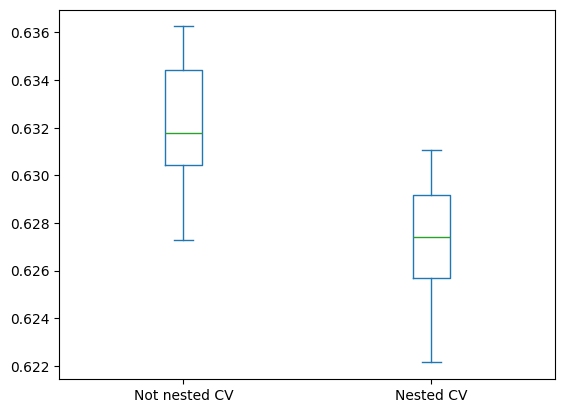

In [9]:
all_scores.plot.box()

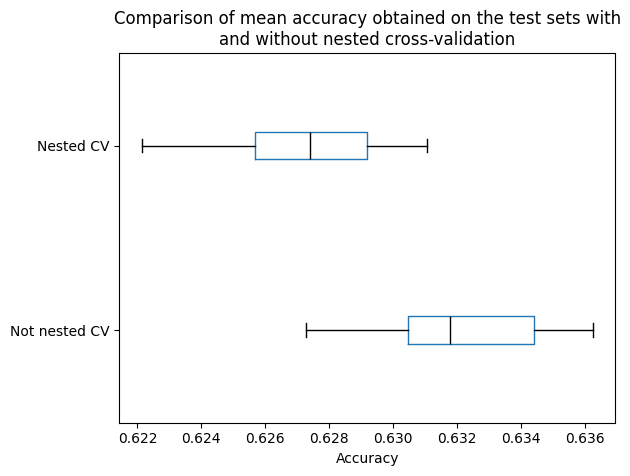

In [10]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title(
    "Comparison of mean accuracy obtained on the test sets with\n"
    "and without nested cross-validation"
)

We observe that the generalization performance estimated without using nested
CV is higher than what we obtain with nested CV. The reason is that the tuning
procedure itself selects the model with the highest inner CV score. If there
are many hyper-parameter combinations and if the inner CV scores have
comparatively large standard deviations, taking the maximum value can lure the
naive data scientist into over-estimating the true generalization performance
of the result of the full learning procedure. By using an outer
cross-validation procedure one gets a more trustworthy estimate of the
generalization performance of the full learning procedure, including the
effect of tuning the hyperparameters.

As a conclusion, when optimizing parts of the machine learning pipeline (e.g.
hyperparameter, transform, etc.), one needs to use nested cross-validation to
evaluate the generalization performance of the predictive model. Otherwise,
the results obtained without nested cross-validation are often overly
optimistic.

Observamos que el rendimiento de generalización estimado sin utilizar CV anidado es mayor que el que obtenemos con CV anidado. La razón es que el propio procedimiento de ajuste selecciona el modelo con la puntuación de CV interna más alta. Si hay muchas combinaciones de hiperparámetros y si las puntuaciones de CV internas tienen desviaciones estándar comparativamente grandes, tomar el valor máximo puede inducir al científico de datos ingenuo a sobrestimar el verdadero rendimiento de generalización del resultado del procedimiento de aprendizaje completo. Al utilizar un procedimiento de validación cruzada externa, se obtiene una estimación más confiable del rendimiento de generalización del procedimiento de aprendizaje completo, incluido el efecto de ajustar los hiperparámetros.

Como conclusión, al optimizar partes del proceso de aprendizaje automático (por ejemplo, hiperparámetro, transformación, etc.), es necesario utilizar la validación cruzada anidada para evaluar el rendimiento de generalización del modelo predictivo. De lo contrario, los resultados obtenidos sin la validación cruzada anidada suelen ser demasiado optimistas.
